# Conformal Selective Classification for UQ

### Pros:
-Valid Coverage Guarantees

-Versatility/Model Agnostic

-User-Friendly Interpretations

### Cons:
-Computational expensive

-Technical and Complex Implementation

## Theoretical framework underpinning this method


Conformal prediction helps us understand how reliable a machine learning model's predictions areis a reliable way. It works by looking at how well new predictions match with past data. If a prediction falls within a certain range that we expect, we can be confident it's accurate. This method gives us a way to see how sure we can be about the model's answers by providing a range of possible outcomes with a set level of confidence.

Conformal Selective Classification is a method explored by Angelopoulos & Bates (2021), in which instead of just giving a single answer, it also tells us when to trust the model's prediction. The approach involves using past data to determine how well a prediction fits, and then deciding if the model’s confidence is high enough to make a decision. If the confidence is too low, the model might say it doesn’t have a reliable answer, helping to avoid mistakes and improving decision-making accuracy.

## Conformal Selective Prediction - Mathematical Approach

### 1. Selective Risk Function
The selective risk function calculates the proportion of incorrect predictions where the model’s confidence is at least $ \lambda $.

$$
\text{selective\_risk}(\lambda) = \frac{\sum_{i : \text{cal\_phats}_i \geq \lambda} \mathbf{1}(\text{cal\_yhats}_i \neq \text{cal\_labels}_i)}{\sum_{i : \text{cal\_phats}_i \geq \lambda} \mathbf{1}}
$$

where:
- $ \mathbf{1}(\text{cal\_phats}_i \geq \lambda) $ is an indicator function that is 1 if $ \text{cal\_phats}_i \geq \lambda $ and 0 otherwise.
- $ \text{cal\_yhats}_i $ is the predicted label for instance $ i $.
- $ \text{cal\_labels}_i $ is the true label for instance $ i $.

### 2. Number of Predictions Above Lambda
The function $ \text{nlambda}(\lambda) $ counts the number of predictions where the confidence is greater than $ \lambda $.

$$
\text{nlambda}(\lambda) = \sum_{i : \text{cal\_phats}_i > \lambda} 1
$$

### 3. Filtering Lambdas
Ensure there are at least 30 data points for each candidate $ \lambda $. This is done by filtering out $ \lambda $ values that do not meet this criterion.

$$
\text{Include } \lambda \text{ if } \text{nlambda}(\lambda) \geq 30
$$

### 4. Invert for Upper Bound
The function $ \text{invert\_for\_ub}(r, \lambda) $ finds the value $ r $ such that the cumulative distribution function (CDF) of a binomial distribution matches a target probability, adjusted by a small constant $ \delta $.

$$
\text{binom.cdf}(k, \text{nlambda}(\lambda), r) = \delta
$$

where:

$$
k = \text{selective\_risk}(\lambda) \times \text{nlambda}(\lambda)
$$

### 5. Construct Upper Bound
The function $ \text{selective\_risk\_ub}(\lambda) $ finds the upper bound for the selective risk given $ \lambda $ by solving:

$$
\text{selective\_risk\_ub}(\lambda) = \text{brentq}(\text{invert\_for\_ub}, 0, 0.9999, \text{args}=(\lambda,))
$$

### 6. Choosing Lambda
The algorithm selects the largest $ \lambda $ for which the upper bound of the selective risk is acceptable:

$$
\text{selective\_risk\_ub}(\lambda - \frac{1}{n}) \leq \alpha
$$

where $ n $ is the number of candidate $ \lambda $ values, and $ \alpha $ is the desired significance level.

### 7. Deploy Procedure
The final threshold $ \hat{\lambda} $ is used to make predictions on new data. Predictions are kept if their confidence is greater than or equal to $ \hat{\lambda} $.

$$
\text{predictions\_kept}_i = 
\begin{cases} 
1 & \text{if } \text{val\_phats}_i \geq \hat{\lambda} \\
0 & \text{otherwise} 
\end{cases}
$$

where $ \text{val\_phats}_i $ is the predicted probability for instance $ i $ in the validation set, and $ \hat{\lambda} $ is the chosen threshold.


### Step 1: Write Import Statements

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import binom
import pandas as pd
import xgboost as xgb
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
!pip install -U --no-cache-dir gdown --pre

### Step 2: Load and pre-process Dataset

In [2]:
df=pd.read_csv("customer_purchase_data.csv")
X = df[['Age', 'Gender','AnnualIncome','NumberOfPurchases','ProductCategory','TimeSpentOnWebsite','LoyaltyProgram','DiscountsAvailed']]
y = df['PurchaseStatus']
df.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

### Step 3: Train XGBoost Model and obtain score predictions

In [4]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric='mlogloss'
)

model.fit(X_train,y_train)
preds=model.predict_proba(X_test)[:,1]
preds=[[1-pred,pred] for pred in preds]
labels=y_test

### Step 4: Define $\alpha$ value (desired Selective Accuracy) and $\delta$ value (desired Failure Rate)

In [22]:
alpha = 1-0.95
delta = 0.75
lambdas = np.linspace(0,1,1000)

### Step 5: Selective accuracy control procedure

In [23]:
cal_smx, val_smx, cal_labels, val_labels = train_test_split(preds, labels, test_size=0.2, random_state=42, shuffle=True)
cal_smx=np.array(cal_smx)
val_smx=np.array(val_smx)
cal_labels=np.array(cal_labels)
val_labels=np.array(val_labels)

cal_yhats = np.argmax(cal_smx,axis=1)
val_yhats = np.argmax(val_smx,axis=1)
cal_phats = cal_smx.max(axis=1)
val_phats = np.max(val_smx,axis=1)

In [29]:
def selective_risk(lam): return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()

def nlambda(lam): return (cal_phats > lam).sum()
lambdas = np.array([lam for lam in lambdas if nlambda(lam) >= 30])

def invert_for_ub(r,lam): return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta


def selective_risk_ub(lam): return brentq(invert_for_ub,0,0.9999,args=(lam,))


for lhat in np.flip(lambdas):
    if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break

predictions_kept = val_phats >= lhat

### Step 6: Calculate relevant metrics

In [26]:
empirical_selective_accuracy = (val_yhats[predictions_kept] == val_labels[predictions_kept]).mean()
print(f"The empirical selective accuracy is: {empirical_selective_accuracy}")
false_flags = (val_yhats[~predictions_kept] == val_labels[~predictions_kept]).mean()
print(f"The fraction of false flags is: {false_flags}")
fraction_kept = predictions_kept.mean()
print(f"The fraction of data points kept is: {fraction_kept}")

The empirical selective accuracy is: 0.9292035398230089
The fraction of false flags is: 0.7142857142857143
The fraction of data points kept is: 0.9416666666666667


### Step 7: Obtain and analyse examples

In [27]:
label_strings=['Class 0', 'Class 1']
_keeps = []
_yhats = []
_labels = []
indexs=[]
labels=np.array(labels)
for i in range(20):
    index=random.randint(1,500)
    indexs.append(index)
    _keeps += [np.max(preds[index]) >= lhat]
    _yhats += [label_strings[np.argmax(preds[index])]]
    _labels += [label_strings[labels[index]]]        
_keeps = np.array(_keeps); _yhats = np.array(_yhats); _labels = np.array(_labels);

for i in range(20):
    print(f"Index: {indexs[i]}| Prediction: {_yhats[i]} | Label: {_labels[i]} | Abstained: {~_keeps[i]}")

Index: 178| Prediction: Class 0 | Label: Class 1 | Abstained: False
Index: 20| Prediction: Class 1 | Label: Class 1 | Abstained: False
Index: 400| Prediction: Class 0 | Label: Class 0 | Abstained: False
Index: 487| Prediction: Class 1 | Label: Class 1 | Abstained: False
Index: 221| Prediction: Class 1 | Label: Class 1 | Abstained: False
Index: 297| Prediction: Class 0 | Label: Class 0 | Abstained: False
Index: 262| Prediction: Class 0 | Label: Class 0 | Abstained: False
Index: 64| Prediction: Class 1 | Label: Class 1 | Abstained: False
Index: 389| Prediction: Class 0 | Label: Class 0 | Abstained: False
Index: 252| Prediction: Class 0 | Label: Class 0 | Abstained: False
Index: 102| Prediction: Class 1 | Label: Class 1 | Abstained: True
Index: 403| Prediction: Class 0 | Label: Class 0 | Abstained: False
Index: 115| Prediction: Class 1 | Label: Class 1 | Abstained: False
Index: 442| Prediction: Class 0 | Label: Class 0 | Abstained: False
Index: 146| Prediction: Class 0 | Label: Class 0 | 

### Step 8: Plot Fraction Kept vs Accuracy

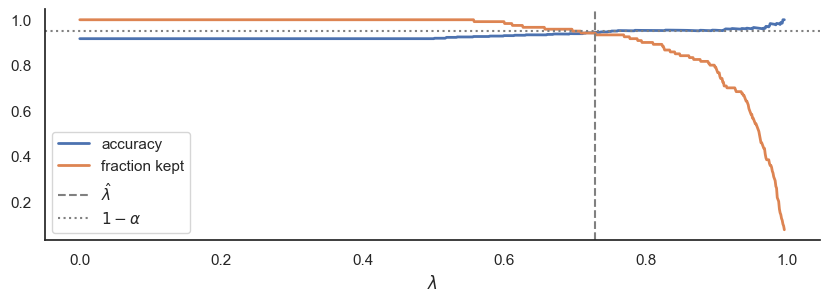

In [28]:
sns.set(style='white')
selective_accuracy_curve = [1-selective_risk(lam) for lam in lambdas]
fraction_kept_curve = [(val_phats >= lam).mean() for lam in lambdas]
fig, axs = plt.subplots(1,figsize=(10,3))
axs.plot(lambdas,selective_accuracy_curve,label='accuracy',linewidth=2)
axs.plot(lambdas,fraction_kept_curve,label='fraction kept',linewidth=2)
axs.axvline(x=lhat,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}$',color='gray')
axs.axhline(y=1-alpha,linewidth=1.5,linestyle='dotted',label=r'$1-\alpha$',color='gray')
sns.despine(ax=axs,top=True,right=True)
axs.legend(loc='lower left')
axs.set_xlabel(r'$\lambda$')
true_nonabstention_idx = np.argmax( (_yhats == _labels) & (_keeps))

## References

1. Angelopoulos, Anastasios N, and Stephen Bates. (2021).  "A gentle introduction to conformal prediction and distribution-free uncertainty quantification."
2. Balasubramanian, Vineeth, Shen-Shyang Ho, and Vladimir Vovk, eds. Conformal prediction for reliable machine learning: theory, adaptations and applications. Newnes, 2014.
3. Shafer, Glenn, and Vladimir Vovk. "A tutorial on conformal prediction." Journal of Machine Learning Research 9.3 (2008).